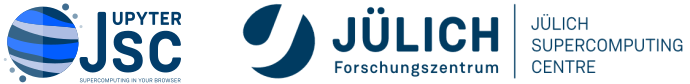
<h5 style="text-align: right">Author: <a href="mailto:j.goebbert@fz-juelich.de?subject=Jupyter4NFDI%20documentation">Jens Henrik Göbbert</a></h5>  
<h5><a href="../index.ipynb">Index</a></h5>
<h1 style="text-align: center">Create your own Jupyter Kernel</h1>  

Often the standard kernel do not provide all features you need for your work. This might be that certain modules are not loaded or packages are not installed.  
With your own kernel you can overcome that problem easily and define your own environment, in which you work.

This notebook shows you how you can build your own kernel for a **python environment**.

<div class="alert alert-block alert-info">
<b>Attention:</b>
This notebook is meant to run out of a JupyterLab on JSC's HPC systems.</br>
</div>

-------------------------

## Building your own Jupyter kernel is a three step process
1. Create/Pimp new virtual Python environment
   * venv
2. Create/Edit launch script for the Jupyter kernel
   * kernel.sh
3. Create/Edit Jupyter kernel configuration
   * kernel.json

### Settings

#### Set the kernel name
  - must be lower case
  - change if you like

In [ ]:
# INPUT NEEDED:
KERNEL_NAME=${USER}_kernel

export KERNEL_NAME=$(echo "${KERNEL_NAME}" | awk '{print tolower($0)}')
echo ${KERNEL_NAME} # double check

#### Set the kernel directory
  - check that the kernel name is unique
  - print the location of the new kernel

In [ ]:
# define KERNEL_SPECS_DIR
export KERNEL_SPECS_PREFIX=${HOME}/.local
if [ ! -d "$KERNEL_SPECS_PREFIX" ]; then
  echo "ERROR: please create directory $KERNEL_SPECS_PREFIX"
fi
export KERNEL_SPECS_DIR=${KERNEL_SPECS_PREFIX}/share/jupyter/kernels

# check if kernel name is unique
if [ -d "${KERNEL_SPECS_DIR}/${KERNEL_NAME}" ]; then
  echo "ERROR: Kernel already exists in ${KERNEL_SPECS_DIR}/${KERNEL_NAME}"
  echo "       Rename kernel name or remove directory."
fi

# print the location of the new kernel
echo ${KERNEL_SPECS_DIR}/${KERNEL_NAME} 

#### Set the kernel's virtual environment
  - by default it is located at $PROJECT
  - print the location of the new kernels virtual environment

In [ ]:
# define KERNEL_VENVS_DIR
export KERNEL_VENVS_DIR=${PROJECT}/${USER}/jupyter/kernels
mkdir -p ${KERNEL_VENVS_DIR}

# print the location of the new kernels virtual environment
echo ${KERNEL_VENVS_DIR}

---

## 1. Create/Pimp new virtual Python environment

#### 1.1 - Load basic Python module

In [ ]:
module purge
module load Stages/2024 # any stage can be used
module load GCC
module load Python      # only Python is mandatory

In [ ]:
# get Python version
export PYV=$(python -c 'import sys; print(".".join(map(str, sys.version_info[:2])))')
echo $PYV

#### 1.2 - Load extra modules you need for your kernel

In [ ]:
# module load <module you need>

#### 1.3 - Create and activate a virtual environment for the kernel  
and ensure python packages installed in the virtual environment are always prefered

In [ ]:
export VIRTUAL_ENV=${KERNEL_VENVS_DIR}/${KERNEL_NAME}
if [ -d "${VIRTUAL_ENV}" ]; then
  echo "ERROR: Directory for virtual environment already ${VIRTUAL_ENV}"
  echo "       Rename kernel name or remove directory."
else
  python -m venv --system-site-packages ${VIRTUAL_ENV}
  source ${VIRTUAL_ENV}/bin/activate
  export PYTHONPATH=${VIRTUAL_ENV}/lib/python${PYV}/site-packages:${PYTHONPATH}
  echo ${VIRTUAL_ENV} # double check
fi

#### 1.4 - Install Python libraries required for communication with Jupyter

In [ ]:
which pip
if [ -z "${VIRTUAL_ENV}" ]; then
  echo "ERROR: Virtual environment not successfully initialized."
else
  pip install ipykernel
fi

#### 1.5 - Install whatever else you need in your Python virtual environment (using pip)

In [ ]:
#pip install <python-package you need>

---

## 2. Create/Edit launch script for the Jupyter kernel

#### 2.1 - Create launch script, which loads your Python virtual environment and starts the ipykernel process inside:

<div class="alert alert-block alert-info">
<b>Attention:</b>
You MUST load the exactly the same modules as you did above for your virtual Python environment.
</div>

In [ ]:
echo '#!/bin/bash'"

# Load basic Python module
module purge
module load Stages/2024
module load GCC
module load Python

# Load extra modules you need for your kernel (as you did in step 1.2)
#module load <module you need>

# Activate your Python virtual environment
source ${VIRTUAL_ENV}/bin/activate
    
# Ensure python packages installed in the virtual environment are always prefered
export PYTHONPATH=${VIRTUAL_ENV}/lib/python${PYV}/site-packages:"'${PYTHONPATH}'"
    
exec python -m ipykernel "'$@' > ${VIRTUAL_ENV}/kernel.sh
chmod +x ${VIRTUAL_ENV}/kernel.sh

cat ${VIRTUAL_ENV}/kernel.sh # double check

---

## 3. Create/Edit Jupyter kernel configuration

#### 3.1 - Create Jupyter kernel configuration directory and files

In [ ]:
python -m ipykernel install --name=${KERNEL_NAME} --prefix ${VIRTUAL_ENV}
export VIRTUAL_ENV_KERNELS=${VIRTUAL_ENV}/share/jupyter/kernels

#### 3.2 - Adjust kernel.json file

In [ ]:
mv ${VIRTUAL_ENV_KERNELS}/${KERNEL_NAME}/kernel.json ${VIRTUAL_ENV_KERNELS}/${KERNEL_NAME}/kernel.json.orig

echo '{
  "argv": [
    "'${KERNEL_VENVS_DIR}/${KERNEL_NAME}/kernel.sh'",
    "-m",
    "ipykernel_launcher",
    "-f",
    "{connection_file}"
  ],
  "display_name": "'${KERNEL_NAME}'",
  "language": "python",
  "metadata": {
   "debugger": true
  }
}' > ${VIRTUAL_ENV_KERNELS}/${KERNEL_NAME}/kernel.json

cat ${VIRTUAL_ENV_KERNELS}/${KERNEL_NAME}/kernel.json # double check

#### 3.3 - Create link to kernel specs

In [ ]:
mkdir -p ${KERNEL_SPECS_DIR}
cd ${KERNEL_SPECS_DIR}
ln -s ${VIRTUAL_ENV_KERNELS}/${KERNEL_NAME} .

echo -e "\n\nThe new kernel '${KERNEL_NAME}' was added to your kernels in '${KERNEL_SPECS_DIR}/'\n"
ls ${KERNEL_SPECS_DIR} # double check

#### 3.4 - Use the kernel
- You can select the new kernel in the top right corner of your notebook or from JupyterLab's Launchpad
- The kernel icon will be added to your launcher, after a while by JupyterLab automatically or once you've restarted the JupyterLab

---

## 4. Cleanup

In [ ]:
deactivate